# Read Overlap Analysis

This is the final step of the Bioliquid analysis. The script reads the aligned, sorted and indexed data from Chr17 and analyzes the overlap.

Original author: Jordan Kruguer

# Import packages

In [14]:
import pandas as pd

# Nanopore S3 Directory

In [ ]:
# s3cmd get --recursive s3://aretian-genomics/nanopore/

# Reference Genome

Info: https://lh3.github.io/2017/11/13/which-human-reference-genome-to-use

In [ ]:
# Pull reference genome from S3
# !s3cmd get s3://aretian-genomics/nanopore/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz

In [ ]:
# !gunzip GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz

In [ ]:
# Index reference genome
# !samtools faidx GCA_000001405.15_GRCh38_no_alt_analysis_set.fna

In [ ]:
# Select chromosomes or regions
# !samtools faidx GCA_000001405.15_GRCh38_no_alt_analysis_set.fna chr17 > chr17_selected.fa

In [ ]:
# Import chromosome 

In [3]:
# Read in fasta files
def read_fasta_genome(fasta_file,chromosome_header):
    clean_data = fasta_file.read().replace("\n", "")
    clean_data = clean_data.replace(chromosome_header,"") # get rid of header

    return clean_data

In [7]:
with open('../../data/raw/chr17_selected.fa') as f:
    chr17_genome = read_fasta_genome(f,'>chr17')

See https://www.bioinformatics.org/sms/iupac.html for IUPAC nucleotide codes

In [10]:
print(f"Unique characters: {list(set(chr17_genome))}") 

Unique characters: ['R', 'S', 'Y', 'C', 'A', 'T', 'N', 'K', 'W', 'G']


In [11]:
print(f"Selected chromosome from reference genome is {len(chr17_genome)} BP long")

Selected chromosome from reference genome is 83257441 BP long


# Chromosome Selection (Nanopore)

In [5]:
!ls

assembly-algorithm		 step1.py
bioliquid_chr17_pompe.bam	 step2.py
bioliquid_chr17_pompe.bam.bai	 step3.py
bioliquid_chr17_pompe_reads.txt  str_pipeline_download_data.ipynb
bioliquid_chr17_pompe.txt	 str_pipeline_step2.sh
chunk2.csv			 str_pipeline_step3.sh
extracted_reads.txt		 temp
families.csv			 Untitled.ipynb
output.bam


In [ ]:
# game_reader

In [17]:
df = pd.read_csv('../../data/processed/bioliquid_chr17_pompe_500reads.txt', delimiter = "\t", error_bad_lines=False)

b'Skipping line 5: expected 21 fields, saw 22\nSkipping line 7: expected 21 fields, saw 22\nSkipping line 18: expected 21 fields, saw 22\nSkipping line 26: expected 21 fields, saw 22\nSkipping line 60: expected 21 fields, saw 22\nSkipping line 78: expected 21 fields, saw 22\nSkipping line 86: expected 21 fields, saw 22\nSkipping line 92: expected 21 fields, saw 22\nSkipping line 94: expected 21 fields, saw 22\nSkipping line 104: expected 21 fields, saw 22\nSkipping line 169: expected 21 fields, saw 22\nSkipping line 189: expected 21 fields, saw 22\nSkipping line 196: expected 21 fields, saw 22\nSkipping line 225: expected 21 fields, saw 22\nSkipping line 249: expected 21 fields, saw 22\nSkipping line 251: expected 21 fields, saw 22\nSkipping line 252: expected 21 fields, saw 22\nSkipping line 287: expected 21 fields, saw 22\nSkipping line 315: expected 21 fields, saw 22\nSkipping line 318: expected 21 fields, saw 22\nSkipping line 324: expected 21 fields, saw 22\nSkipping line 343: exp

In [18]:
df.head()

6d90ffed-f2ed-4bf5-8fbe-d3bba26235d1    0  chr17  22936972  11  \
0  18774bb9-0318-401e-88e3-1b246fc20b08  272  chr17  22963300   0   
1  18774bb9-0318-401e-88e3-1b246fc20b08  272  chr17  22968061   0   
2  c191972e-78e4-4703-9c6b-7b7c4ba8a9b4  272  chr17  22971711   0   
3  ebdd1129-003a-4f8d-acb4-72f40f4bbec8  272  chr17  22976053   0   
4  5aeb06ea-b65d-4be2-afa1-d6889fd66533  256  chr17  22980745   0   

  29S94M1I243M2D34M4D49M3I2M2D78M1D98M1D75M2D49M1D87M1D28M1D4M1D88M2D171M2D69M1I188M1D48M1I12M3I57M3D1M1D6M1D4M1I2M1I13M1I52M1D116M1D59M1D10M1I29M1D52M1D279M1D107M1I7M2I1M1D5M2I126M1I299M1I2M2D19M2I88M1I16M1D20M2D59M1I48M1I6M2D93M1D25M1D26M1I65M2I9M1D7M1I1M1I86M1I12M1I8M2D51M1I171M1D29M1I98M1I18M1I22M2I17M1D24M1I28M1D4M1I67M1I20M1D85M1D159M2D43M1D19M1I108M1D5M1D57M1I194M1I14M2D41M1D24M1I329M1I25M1I13M3D154M1D10M2D6M1D29M1I27M2I84M2I60M1I110M2D93M1D6M1I42M1D3M2I5M1D8M1D51M1D185M1I21M1D14M1D13M2D18M3D33M1D72M4I1M1D50M3D10M1I108M2D16M1D12M3I41M1D36M3I7M1D100M1D170M1D4M1I38M1D94M1D1M2D155M1D65M1I29M1I4M1D53M1I18M1D156M1I3M1D85M1I35M2D82M1I60M1D15M1D10M2I42M1D36M1I3M1D41M2I9M1I151M2D3M1D52M1D27M1D38M1D120M3D130M1I2M1I6M1D113M1I40M1I79M3D33M1D54M1I25M1I43M3I9M1D1M3D2M1I14M1D65M1D52M1I25M1I22M2D102M1I141M1D139M2D21M1I58M1D30M1D87M1I74M1I24M2I43M1I26M1I42M1D31M1I374M1D9M3D16M1I108M2I10M1D15M1I46M1D29M2D9M1I35M1D125M2D129M3D32M1I53M1D18M1D25M1D239M1I27M1I73M1D192M1D41M2D98M1D195M1D37M1I5M1D86M1D60M1D129M1I60M1I424M1D5M1I4M3I2M2D4M2D2M2I4M1I44M1D119M1D46M1D28M3D25M2D15M3D10M1D11M1D12M2D6M2D10M3I6M1I7M1D1M2D11M3I3M2I4M2D6M1D7M1D1M1D5M1D5M2D4M1D1M1D8M1D25M1D4M1I6M1D20M1I8M1D6M1D1M1D9M3D5M1I3M1D7M2I77M2D18M1D72M1D43M1D3M1D57M1D75M1I4M1I87M1I12M1D32M1I52M1D229M5D1M1D16M1I26M1I2M2I68M1I7M1D24M1D24M1D95M2D19M1I6M1I82M1I4M1D76M1D14M1D15M1D92M1D46M1D7M1I5M2D8M2D38M1D100M1I196M1D7M1D37M1I109M2D63M3D103M7D17M1D68M1I102M1I87M1I29M1D11M3D11M1D119M1D2M4I1M1I5M1I1M1I58M1D228M2D138M1I36M1I11M2D115M1D16M1D60M1D33M1D234M1D1M1D145M1I70M1I52M1I74M2D1M1D3M2D17M1D38M1D135M2D167M1D283M2I79M2I61M2I2M1D124M1D47M1I83M1D5M1I215M1D47M1D62M1I1M2D20M1I142M1D49M1D49M1I53M1I63M1I48M1D344M1D86M1I5M1D145M1I117M2D44M2D5M1D131M1D51M1I141M1I88M1D28M3D93M1D8M1D4M1I62M1I31M1I48M1I6M1D9M1D39M1D3M1I3M1D58M1I14M2D3M1D15M3D3M1I3M2D48M1I173M1D7M2D1M1I44M1D22M2D105M1D17M1I70M1I100M1D84M1D6M1D78M1I4M1I27M2D60M2I3M1D4M4D106M1D5M1I44M1D70M1I51M2D177M2D3M1D7M2I61M1I101M1D112M1I86M2D18M2I130M1I79M2D28M3D21M2D65M1D36M1D18M2D48M2D31M1D17M1I87M1D64M1D202M2D20M2D4M2D45M1I77M1I262M1D167M1I146M1D3M1D5M1I5M1D7M1I29M3I61M1D159M1D112M2I209M1I8M1I68M4D4M2D21M1D130M2D112M2I73M1D25M1D82M1I8M2I8M1D9M1I60M1D37M1D7M2I2M2I4M1D2M1D67M1D7M1I72M1D97M2I50M1D28M1I35M3D27M1D55M1I110M1D36M2D4M2I5M1D127M1D17M1D73M1I24M1D27M1D4M1I66M1I19M1D13M1D108M2I44M1D147M1I21M1I47M1I40M1D290M2D71M1D6M1I89M1D11M1D14M1D11M1I5M1D48M1D38M1I9M2I218M1D88M2I4M1I22M3I2M1D27M1I1M1I15M1I9M4I310M1D57M1I101M2I67M4D128M1D54M2I94M1I4M1D42M1I103M1D89M1I62M3D3M1I59M1I4M1D27M1I8M1D3M2D2M1I54M3I1M1I20M1D26M1D6M1D7M1D102M1D123M1D17M1D6M1I4M1D6M1I30M1D26M1D42M2D80M1I2M2I105M1D55M1D103M1I25M1I59M1D17M2D21M1D122M1I7M1I120M1I7M1D70M1I99M1D1M2D20M2I33M1I33M1I151M1D40M1I28M1D30M2I8M1I2M1I3M1I24M2I5M1I10M1D198M2D138M1D68M1I45M1D29M2D85M2D118M1D131M2D8M1D178M1I4M2I185M1I5M1I21M1D24M2D44M2D208M1D25M1D91M1I105M2D103M2I81M4D31M1D14M1I77M1I8M1I107M1D17M1I144M1D228M1D22M1I33M1D5M1D47M1D62M1D141M2D16M1I2M1D2M1D3M2D12M1D12M1D55M1D66M2D62M1D45M1I78M1I26M1D45M1I21M2I74M1I69M2D130M2D59M4I3M2D78M1D173M3D190M1I29M2I89M1D14M1D8M1D21M1I81M1D69M1I33M1I2M2I130M1D23M1D33M1D9M2D22M1I4M1D8M1I259M2D61M1D5M1I1M1I11M2D66M1D103M1I34M1D4M3I1M1D66M1I84M1D8M1I2M1D7M1D2M1I66M2D9M1D9M2I83M1D47M2D44M2I96M1D69M1D129M1D89M3D8M1I45M9D3M6D23M1D11M1D115M2D4M2D71M1I86M1I31M1I8M1D17M2D39M1D78M2I19M2D58M1D23M1I146M2I88M2I51M1I6M3D192M1I245M6D178M1D26M4D1M3D12M8I50M1D29M1D19M1I7M1I3M1D5M1D5M1I88M1D46M1I10M1D68M3D27M1D16M1I80M2I228M1I31M4I6M1I14M1D41M3D16M3I137M1I5M1D1M1D25M1D3M2D18M1D144M1D38M2I62M1D24M1D19M1D123M2D31M2I60M2I8M1D139M1D78M3D65M1D25M3D2M1D4M1D8M2D146M1D9M1I63M1D7M1D

In [ ]:
DataFrame.from_records(data, columns=['readID', 'unknown1', 'chromosome', 'start_index','sequence_description','unknown2','unknown3','unknown4','sequence','quality']) 

In [20]:
import csv
import time

reads = []
with open('../../data/processed/bioliquid_chr17_pompe_500reads.txt', newline = '') as games:                                                                                          
    game_reader = csv.reader(games, delimiter='\t')
    
    for game in game_reader:
        time.sleep(1) # prevent memory read rate error
        reads.append(game) 
        #print(game)

In [ ]:
nanopore_reads = pd.DataFrame.from_records(data)

In [ ]:
# Read in fasta files and convert to pandas dataframe
def read_fasta_nanopore(fasta_file,chromosome_header):
    clean_data = fasta_file.read().replace("\n", "")
    #clean_data = clean_data.replace(chromosome_header,"") # get rid of header

    return clean_data

In [ ]:
with open('./assembly-algorithm/data/nanopore_chr17.fa') as f:
    chr17_nanopore_reads = read_fasta_nanopore(f,'>chr17')

In [ ]:
nanopore_chr17

In [ ]:
# Pull reads from chr17
!samtools view bioliquid_chr17_pompe.bam | head -n 5000 > bioliquid_chr17_pompe_5000reads.txt

# Sliding Window Assembly Algorithm (V1)

- Pad left-right on reference genome
- Create sliding window ~5000 BP
    - Avg. read length ~23,452
- Cluster on each window
- Slide window + jump_length
    - Jump length ~1000 BP
 

#### Padding left-right on reference genome

#### Create sliding window of length 5000 bp

In [ ]:
Perform clustering by positioning sliding window in position 0
Move window to 0 + jump_length
Jump_length: 1000
Perform clustering again and repeat
Chr17 total length: 80M. If jump_length=1000, total number of iterations = 80K

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [60]:
#reads = pd.read_csv('bioliquid_chr17_pompe_100reads.csv')
reads = pd.read_csv('../../data/processed/bioliquid_chr17_pompe_500reads.csv')

In [61]:
reads.shape

(500, 22)

In [24]:
#reads['start_index'] = reads['unknown2']

In [62]:
test = reads[0:105]
test.head()

,ID,Unnamed: 1,chromosome,start_index,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,sequence,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,0d4fba3f-2877-4045-b19e-9b7d943f6469,16,chr17,22999284,1,15043S133M1D5M3D11M1I139M1D143M1D152M1I12M1I13...,*,0,0,TTTTGTGGAATCTGCAAGTGGATATGTGGACCTCTCCGAAGATGTC...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8801acf9-9940-4a19-9a17-434b294366ba,16,chr17,23015179,5,16S31M1D6M1D15M4I4M1D1M3D2M3D7M1I63M1D4M1D10M1...,*,0,0,TTTTGAAAACACTATTTGTAGAATCTGCAAGTGGATATTTGGGCCT...,...,ms:i:1742,AS:i:1742,nn:i:0,tp:A:P,cm:i:8,s1:i:81,s2:i:65,de:f:0.1072,rl:i:1008,NaN
2,b48eebff-290b-4735-b984-2e80c9ad9b1c,0,chr17,23101824,1,29S8M2D49M1D5M3I108M1D26M1I26M1D28M1D76M1D173M...,*,0,0,TTGTGTGGTTCTGGTTAGTTTCGTATTGCTTCCTTTTGAGAGAAGC...,...,ms:i:972,AS:i:972,nn:i:0,tp:A:P,cm:i:31,s1:i:260,s2:i:260,de:f:0.0342,rl:i:351,NaN
3,b8dd285a-f37c-4ddb-b23e-4ac637494fac,16,chr17,23012572,0,1364S30M1D19M2D6M1D46M1D12M1D31M2D124M1D80M1I2...,*,0,0,TTGTGATTTGAATGCATAATTTTGTGATAACCCGTTCCGTTTAATT...,...,ms:i:2758,AS:i:2758,nn:i:0,tp:A:P,cm:i:74,s1:i:692,s2:i:681,de:f:0.0516,"SA:Z:chr17,23150884,+,1913S1069M172D98S,7,329;",rl:i:1094
4,8764601d-7a10-4c6e-9199-d5a3c66711d6,16,chr17,23087602,3,3S25M1D76M1I98M1D15M1I69M5I12M1I5M1I49M1D49M1D...,*,0,0,TTGGGGAGGGCCTTAAGGTTTGTGGTGGAAAGGAAATATCTCCACA...,...,ms:i:2054,AS:i:2054,nn:i:0,tp:A:P,cm:i:55,s1:i:472,s2:i:469,de:f:0.0319,rl:i:691,NaN


In [64]:
test.columns

Index(['ID', 'Unnamed: 1', 'chromosome', 'start_index', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'sequence',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')

In [63]:
for ID in test.index:
    print(f"{test.loc[ID,'start_index']}, {len(test.loc[ID,'sequence'])}")

22999284, 32759
23015179, 1385
23101824, 580
23012572, 3080
23087602, 1191
23014434, 1633
23061851, 3700
22975697, 32759
23052482, 1874
23047680, 1103
23013760, 3295
23015123, 6736
23008122, 1896
23075330, 6902
23073904, 19972
23033842, 32759
23006151, 26632
23071824, 32759
23015858, 1842
23111057, 2816
23065231, 6130
23015337, 1409
23015550, 3965
22983246, 19609
23060373, 14163
23085852, 5247
23004186, 2416
23030913, 32759
22936972, 32759
23024826, 1746
23006975, 11655
23015383, 2354
23015572, 4404
22984020, 22347
23054052, 18649
22990548, 32759
23068543, 2339
23064241, 8105
23073112, 32759
23116370, 32759
23078243, 685
23015495, 30901
23063159, 644
23011493, 5430
22997071, 13985
23111594, 21366
23014423, 5256
23045163, 21031
23079994, 5457
23029703, 899
23066090, 1904
23092675, 548
23010327, 29026
23054123, 4702
22990923, 32759
23081618, 30138
23049910, 1063
23116549, 372
23047401, 25797
23049378, 4542
23055024, 10205
23015681, 4476
23012918, 743
23046356, 2218
23053189, 1982
2308744

In [65]:
end_index = max(test['start_index']) + len(test.loc[test['start_index'].idxmax(),'sequence'])
start_index = min(test['start_index'])
index_range = end_index-start_index

In [66]:
index_range

179949

In [72]:
read_overlap = np.zeros((len(test),index_range)) # empty matrix for reads

In [74]:
print(f"The matrix of reads is of size {index_range} x {len(test)}")

The matrix of reads is of size 179949 x 105


In [73]:
for ID in test.index:
    print(f"Adding read cover for read {ID+1}: Index-->{test.loc[ID,'start_index']}, length-->{len(test.loc[ID,'sequence'])}")
    start = test.loc[ID,'start_index']-start_index
    #print(start)
    end = start+len(test.loc[ID,'sequence'])
    #print(end)
    read_overlap[ID,start:end] = 1

Adding read cover for read 1: Index-->22999284, length-->32759
Adding read cover for read 2: Index-->23015179, length-->1385
Adding read cover for read 3: Index-->23101824, length-->580
Adding read cover for read 4: Index-->23012572, length-->3080
Adding read cover for read 5: Index-->23087602, length-->1191
Adding read cover for read 6: Index-->23014434, length-->1633
Adding read cover for read 7: Index-->23061851, length-->3700
Adding read cover for read 8: Index-->22975697, length-->32759
Adding read cover for read 9: Index-->23052482, length-->1874
Adding read cover for read 10: Index-->23047680, length-->1103
Adding read cover for read 11: Index-->23013760, length-->3295
Adding read cover for read 12: Index-->23015123, length-->6736
Adding read cover for read 13: Index-->23008122, length-->1896
Adding read cover for read 14: Index-->23075330, length-->6902
Adding read cover for read 15: Index-->23073904, length-->19972
Adding read cover for read 16: Index-->23033842, length-->3275

In [75]:
# Vector of depths (length 180K)
summary = read_overlap.sum(axis=0)

In [78]:
start_index

22936972

In [79]:
end_index

23116921

In [85]:
df = pd.DataFrame(summary,index=range(start_index,end_index), columns=['overlap_count'])

In [86]:
df['position'] = df.index

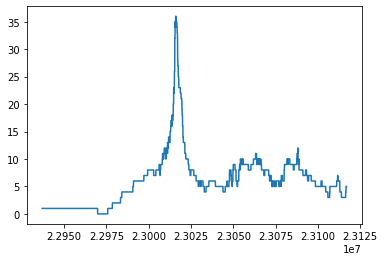

In [87]:
plt.plot(df['position'],df['overlap_count'])

In [84]:
index_range

179949

# Clustering

In [88]:
left_bound = 23000000

In [89]:
test.head(1)

,ID,Unnamed: 1,chromosome,start_index,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,sequence,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,0d4fba3f-2877-4045-b19e-9b7d943f6469,16,chr17,22999284,1,15043S133M1D5M3D11M1I139M1D143M1D152M1I12M1I13...,*,0,0,TTTTGTGGAATCTGCAAGTGGATATGTGGACCTCTCCGAAGATGTC...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
#sequences = {}
sequences = []

In [92]:
for ID in test.index:
    sequence = list(test.loc[ID,'sequence']) # turn sequence string into list
    
    start = test.loc[ID,'start_index']-left_bound
    
    if start > 0: # sequence starts to the right of the bound
        
        sequence = (start*['X'])+sequence
        sequence_trimmed = ''.join(sequence) # keep entire sequence
        
        
    elif start < 0: # sequence starts to the left of the bound
        sequence_trimmed = ''.join(sequence[np.abs(start):])
        
                                    
    #sequences[test.loc[ID,'ID']] = sequence_trimmed
    sequences.append(sequence_trimmed)
    

In [100]:
longest_sequence_length = len(max(sequences, key=len)) # get longest sequence

In [101]:
for i in range(len(sequences)):
    pad_length = longest_sequence_length - len(sequences[i])
    sequence = list(sequences[i])
    sequence = sequence+(pad_length*['X'])
    sequence = sequence[0:3000] # ADDED - RANGE from start index
    sequence = ''.join(sequence)
    sequences[i] = sequence

In [102]:
test['sequence_area_of_interest'] = sequences

<ipython-input-102-b12734048ee6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sequence_area_of_interest'] = sequences


In [103]:
test.head()

,ID,Unnamed: 1,chromosome,start_index,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,sequence,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,sequence_area_of_interest
0,0d4fba3f-2877-4045-b19e-9b7d943f6469,16,chr17,22999284,1,15043S133M1D5M3D11M1I139M1D143M1D152M1I12M1I13...,*,0,0,TTTTGTGGAATCTGCAAGTGGATATGTGGACCTCTCCGAAGATGTC...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TGGACCGCTTTGAGGCCTATGGTAGTAAAGGATAGCTTCATATAAA...
1,8801acf9-9940-4a19-9a17-434b294366ba,16,chr17,23015179,5,16S31M1D6M1D15M4I4M1D1M3D2M3D7M1I63M1D4M1D10M1...,*,0,0,TTTTGAAAACACTATTTGTAGAATCTGCAAGTGGATATTTGGGCCT...,...,AS:i:1742,nn:i:0,tp:A:P,cm:i:8,s1:i:81,s2:i:65,de:f:0.1072,rl:i:1008,NaN,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...
2,b48eebff-290b-4735-b984-2e80c9ad9b1c,0,chr17,23101824,1,29S8M2D49M1D5M3I108M1D26M1I26M1D28M1D76M1D173M...,*,0,0,TTGTGTGGTTCTGGTTAGTTTCGTATTGCTTCCTTTTGAGAGAAGC...,...,AS:i:972,nn:i:0,tp:A:P,cm:i:31,s1:i:260,s2:i:260,de:f:0.0342,rl:i:351,NaN,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...
3,b8dd285a-f37c-4ddb-b23e-4ac637494fac,16,chr17,23012572,0,1364S30M1D19M2D6M1D46M1D12M1D31M2D124M1D80M1I2...,*,0,0,TTGTGATTTGAATGCATAATTTTGTGATAACCCGTTCCGTTTAATT...,...,AS:i:2758,nn:i:0,tp:A:P,cm:i:74,s1:i:692,s2:i:681,de:f:0.0516,"SA:Z:chr17,23150884,+,1913S1069M172D98S,7,329;",rl:i:1094,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...
4,8764601d-7a10-4c6e-9199-d5a3c66711d6,16,chr17,23087602,3,3S25M1D76M1I98M1D15M1I69M5I12M1I5M1I49M1D49M1D...,*,0,0,TTGGGGAGGGCCTTAAGGTTTGTGGTGGAAAGGAAATATCTCCACA...,...,AS:i:2054,nn:i:0,tp:A:P,cm:i:55,s1:i:472,s2:i:469,de:f:0.0319,rl:i:691,NaN,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...


In [104]:
import numpy as np
NUCLEOTIDE_VOCABULARY = [
    'A','C','G','T','X'
]
        
def nucleotide_to_one_hot(nucleotide_sequence):
    to_return = []
    for char in nucleotide_sequence:
        if char in NUCLEOTIDE_VOCABULARY:
            to_append = np.zeros(len(NUCLEOTIDE_VOCABULARY))
            to_append[NUCLEOTIDE_VOCABULARY.index(char)] = 1.
            to_return.append(to_append)
        else:
            raise ValueError('Could not one-hot code character {}'.format(char))
    return np.array(to_return)

nucleotide_to_one_hot('GTCATACX') # example

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [105]:
sequences_test = []

In [106]:
for seq in sequences:
    sequences_test.append(list(seq))

In [107]:
test['sequence_one_hot'] = test.sequence_area_of_interest.apply(lambda x: nucleotide_to_one_hot(x).flatten())  # Map variants that have insertions or deletions to all zeros (483 of them).

<ipython-input-107-6d3f48337329>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sequence_one_hot'] = test.sequence_area_of_interest.apply(lambda x: nucleotide_to_one_hot(x).flatten())  # Map variants that have insertions or deletions to all zeros (483 of them).


In [108]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X = enc.fit_transform(sequences_test).toarray()

In [109]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(X_pca)

[[ 5.88658724e+01  6.12668670e+00]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [ 5.89925146e+01 -7.80238941e+00]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [ 5.59189814e+01  2.96921569e+01]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1.42437184e-02]
 [-4.82545104e+00 -1

In [118]:
test['PCA1'] = np.nan
test['PCA2'] = np.nan
for ID in test.index:
    test.loc[ID,'PCA1'] = X_pca[ID][0].round(5)
    test.loc[ID,'PCA2'] = X_pca[ID][1].round(5)

<ipython-input-118-0cb266d7bb3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PCA1'] = np.nan
<ipython-input-118-0cb266d7bb3f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PCA2'] = np.nan
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

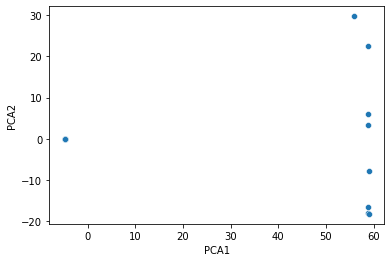

In [119]:
import seaborn as sns
sns.scatterplot(data=test,x='PCA1',y='PCA2')

Text(0, 0.5, 'Distortion')

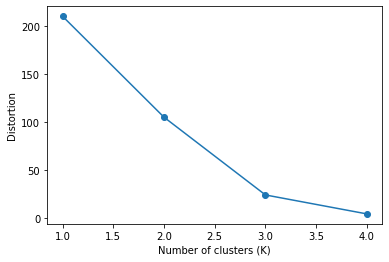

In [120]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Standardizing the features
X = test[['PCA1','PCA2']]
X = StandardScaler().fit_transform(X)

distortions = []

for k in range(1, 5):
    KMeans_model = KMeans(n_clusters=k, random_state=42)
    KMeans_model.fit(X)
    distortions.append(KMeans_model.inertia_)

plt.plot(range(1, 5), distortions,  marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion')

In [121]:
silhouette_scores = []
for k in range(2, 5):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    score = silhouette_score(X, model.labels_)
    print("Silhouette Score for k = ", k, "is", score)
    silhouette_scores.append(score)

Silhouette Score for k =  2 is 0.931959460413601
Silhouette Score for k =  3 is 0.9655743551256758
Silhouette Score for k =  4 is 0.9781213103688307


Text(0, 0.5, 'Silhouette score')

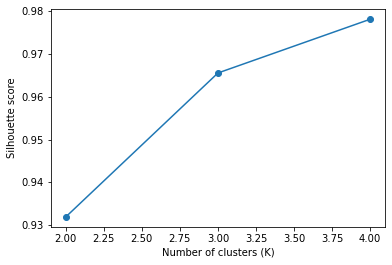

In [122]:
plt.plot(range(2, 5), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette score')

In [123]:
from yellowbrick.cluster import KElbowVisualizer

visualizer3 = KElbowVisualizer(KMeans(), k=(2,5))

visualizer3.fit(X) # Fit the data to the visualizer

ModuleNotFoundError: No module named 'yellowbrick'

In [124]:
model = KMeans(n_clusters=2, random_state=42)
cls2 = model.fit(X)
test['kmeans_cls2'] = cls2.labels_

<ipython-input-124-7fccd5925abe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['kmeans_cls2'] = cls2.labels_


In [ ]:
# !echo 'hello' >> mother.bam

In [125]:
test

,ID,Unnamed: 1,chromosome,start_index,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,sequence,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,sequence_area_of_interest,sequence_one_hot,kmeans_cls2,PCA1,PCA2
0,0d4fba3f-2877-4045-b19e-9b7d943f6469,16,chr17,22999284,1,15043S133M1D5M3D11M1I139M1D143M1D152M1I12M1I13...,*,0,0,TTTTGTGGAATCTGCAAGTGGATATGTGGACCTCTCCGAAGATGTC...,...,NaN,NaN,NaN,NaN,NaN,TGGACCGCTTTGAGGCCTATGGTAGTAAAGGATAGCTTCATATAAA...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",1,58.86587,6.12669
1,8801acf9-9940-4a19-9a17-434b294366ba,16,chr17,23015179,5,16S31M1D6M1D15M4I4M1D1M3D2M3D7M1I63M1D4M1D10M1...,*,0,0,TTTTGAAAACACTATTTGTAGAATCTGCAAGTGGATATTTGGGCCT...,...,s1:i:81,s2:i:65,de:f:0.1072,rl:i:1008,NaN,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,-4.82545,-0.01424
2,b48eebff-290b-4735-b984-2e80c9ad9b1c,0,chr17,23101824,1,29S8M2D49M1D5M3I108M1D26M1I26M1D28M1D76M1D173M...,*,0,0,TTGTGTGGTTCTGGTTAGTTTCGTATTGCTTCCTTTTGAGAGAAGC...,...,s1:i:260,s2:i:260,de:f:0.0342,rl:i:351,NaN,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,-4.82545,-0.01424
3,b8dd285a-f37c-4ddb-b23e-4ac637494fac,16,chr17,23012572,0,1364S30M1D19M2D6M1D46M1D12M1D31M2D124M1D80M1I2...,*,0,0,TTGTGATTTGAATGCATAATTTTGTGATAACCCGTTCCGTTTAATT...,...,s1:i:692,s2:i:681,de:f:0.0516,"SA:Z:chr17,23150884,+,1913S1069M172D98S,7,329;",rl:i:1094,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,-4.82545,-0.01424
4,8764601d-7a10-4c6e-9199-d5a3c66711d6,16,chr17,23087602,3,3S25M1D76M1I98M1D15M1I69M5I12M1I5M1I49M1D49M1D...,*,0,0,TTGGGGAGGGCCTTAAGGTTTGTGGTGGAAAGGAAATATCTCCACA...,...,s1:i:472,s2:i:469,de:f:0.0319,rl:i:691,NaN,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,-4.82545,-0.01424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,ebdd1129-003a-4f8d-acb4-72f40f4bbec8,16,chr17,22978432,1,6925S15M1D2M1D9M1D52M2I4M1D10M5D76M1I4M2I70M1D...,*,0,0,AATGTATTGCTGAAACTCTCTCGTGATGATTGCATTCAACTCACAG...,...,NaN,NaN,NaN,NaN,NaN,GTCACATTGCTTTCCATAGAGTAGTTCTGAAATGTGCTTTGCAGTG...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,58.90624,3.42259
101,9c52e02c-24f7-4ce5-8bd8-943008fda767,16,chr17,23107071,1,5205S15M1I63M1I8M4D171M1I178M1D101M1I19M2D28M2...,*,0,0,AATATTGTTAAGTGTGTTTTAAACTCTTTTTCATCAGCTTGCGTGT...,...,s1:i:2179,s2:i:2204,de:f:0.0452,"SA:Z:chr17,22895323,+,5829S5178M603D33S,1,1537;",rl:i:4173,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,-4.82545,-0.01424
102,05a4f236-5d2f-4083-94cf-b80ac7aa8660,16,chr17,23013791,1,16M1D76M1I99M1D48M1D2M1D14M2D6M3I79M1I39M2I14M...,*,0,0,AAGAGCAGTGATGAAAACTCTTTTTCTAGAATCTGCAAGTGGACGT...,...,s1:i:58,s2:i:66,de:f:0.1291,rl:i:4222,NaN,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,-4.82545,-0.01424
103,6b17167f-ef76-4fa7-a41b-26f4459d43fb,2048,chr17,23082261,1,29H40M1D108M1I166M2D44M2D17M1D34M2D2M1D21M1D29...,*,0,0,AACTCACAGAGCTGAACATTCCTTGCGATGTAGCAGTTTCAAACAC...,...,s1:i:60,s2:i:57,de:f:0.101,"SA:Z:chr17,23498874,+,2969S46556M1085D1709S,1,...",rl:i:41007,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,-4.82545,-0.01424


<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

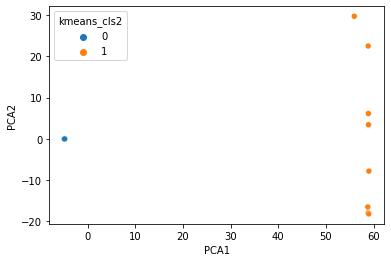

In [126]:
import seaborn as sns
sns.scatterplot(data=test,x='PCA1',y='PCA2',hue='kmeans_cls2')